# Time Series Intro

The study of time series has arisen because certain sorts of data streams are heavily dependent on the flow of time. Of course, we have not totally ignored time as a feature up to this point. The selling price of a house probably *does* have some relation to the season or the year as real estate markets grow and decline with certain temporally-indexed economic changes etc. But surely time is not the most important predictor of house price. Square footage would likely be more strongly correlated with price than would date of sale.

But there are other sorts of data that more readily lend themselves to a temporal analysis. One canonical example is numbers from a stock exchange: First, data from stock tickers often arrive as numbers anchored to consecutive units of time. I get the selling price for some stock on January 1, say, and the next bit of information I gain will be the selling price for that stock on January 2. (We'll explore this feature of time series below.) Second, and more important, if I'm interested in actually *predicting* the selling price of a stock for, say, tomorrow, then very likely one piece of very salient (i.e. *correlated*) information would be the selling price of that stock *today*.

What other examples of this sort of time-dependent data can you think of?

- temperature
- flowering phenology
- sunspots
- hormonal cycles

In [1]:
# Let's load some packages.

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder

In [2]:
pd.read_csv('data/google-trends_game-of-thrones_us.csv').head()

,Category: All categories
Month,"""game of thrones"": (United States)"
2004-01,<1
2004-02,<1
2004-03,<1
2004-04,<1


In [3]:
# Define a function that will help us load and
# clean up a dataset.

def load_trend(trend_name='football', country_code='us'):
    df = pd.read_csv('data/google-trends_'
                     + trend_name + '_'
                     + country_code
                     + '.csv').iloc[1:, :]
    df.columns = ['counts']
    df['counts'] = df['counts'].str.replace('<1', '0').astype(int)
    return df

In [4]:
df = load_trend(**{'trend_name': 'data-science', 'country_code': 'us'})

The `**` syntax is used to pass keywords and values in dictionary form to a function. For more on `*` and `**` (`*args` and `**kwargs`), see [this page](https://www.geeksforgeeks.org/args-kwargs-python/).

In [5]:
trends = [
    {'trend_name': 'data-science', 'country_code': 'us'},
    {'trend_name': 'football', 'country_code': 'us'},
    {'trend_name': 'football', 'country_code': 'uk'},
    {'trend_name': 'game-of-thrones', 'country_code': 'us'},
    {'trend_name': 'pokemon', 'country_code': 'us'},
    {'trend_name': 'taxes', 'country_code': 'us'},   
]

In [6]:
np.random.shuffle(trends)

In [7]:
trend_dfs = [load_trend(**trend) for trend in trends]

In [239]:
#trend_df = trend_dfs[0]

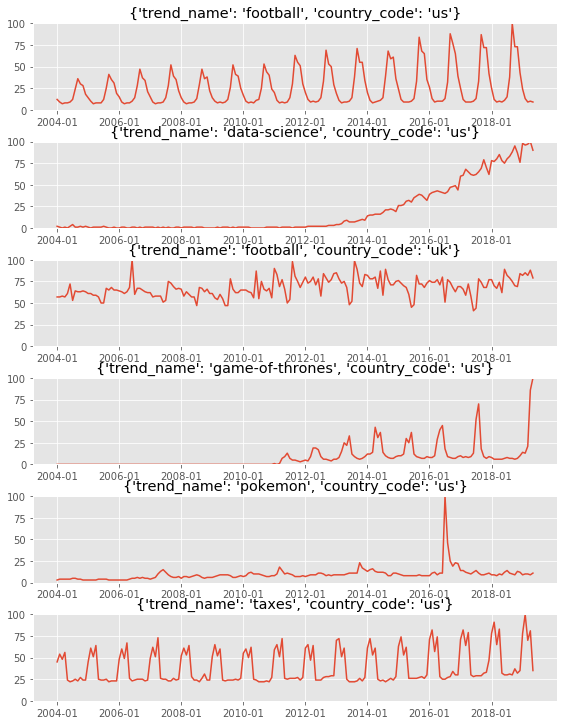

In [9]:
# Let's see if we can guess which is which just by looking
# at their graphs.

import matplotlib; matplotlib.style.use('ggplot')

fig, axs = plt.subplots(len(trend_dfs), 1, figsize=(8, 10))
plt.tight_layout()
for i, trend_df in enumerate(trend_dfs):
    ax = axs[i]
    ax.set_title(str(trends[i]))
    ax.plot(np.array(trend_df.index), trend_df['counts'])
    ticks = ax.get_xticks()
    ax.set_ylim((0, 100))
    ax.set_xticks([tick for tick in ticks if tick%24 == 0])

We could do a histogram of our data, say of the taxes counts:

In [10]:
taxes_df = load_trend('taxes')

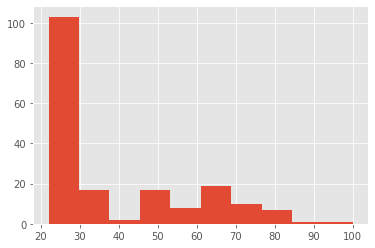

In [11]:
plt.hist(taxes_df['counts']);

But clearly we would be missing something important about how the data is structured. Let's try to capture that. We'll stick with the taxes data.

In [12]:
taxes_df.head()

,counts
2004-01,45
2004-02,54
2004-03,48
2004-04,56
2004-05,24


In [13]:
# Adding a month column

taxes_df['i'] = np.arange(len(taxes_df))
taxes_df['month'] = taxes_df['i'] % 12

In [14]:
# Using month to predict tax activity

trend_model = LinearRegression()
trend_model.fit(taxes_df[['i']], taxes_df['counts'])
trend_line = trend_model.predict(taxes_df[['i']])

In [15]:
trend_line[:12]

array([31.65754141, 31.73558811, 31.81363481, 31.89168151, 31.96972821,
       32.04777491, 32.12582161, 32.20386831, 32.28191501, 32.35996171,
       32.43800842, 32.51605512])

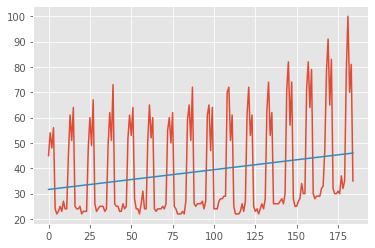

In [16]:
plt.plot(taxes_df['i'], taxes_df['counts'])
plt.plot(taxes_df['i'], trend_line);

Clearly, this model leaves something to be desired! Let's try again. And this time we'll make explicit use of the time indices.

In [17]:
month_encoder = OneHotEncoder(categories='auto')
month_encoder.fit(taxes_df[['month']])
month_data = month_encoder.transform(taxes_df[['month']]).toarray()

In [18]:
month_data[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [19]:
lr = LinearRegression()

In [20]:
data = np.hstack((taxes_df[['i']].values, month_data))

In [21]:
data[0]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [22]:
lr.fit(data, taxes_df['counts'])
lr_pred = lr.predict(data)  # Predictive model based on i and month

In [23]:
lr_pred[:12]

array([52.63422131, 63.19672131, 46.88422131, 60.50922131, 19.63422131,
       17.83360656, 18.10027322, 18.36693989, 18.63360656, 21.16693989,
       18.96693989, 21.70027322])

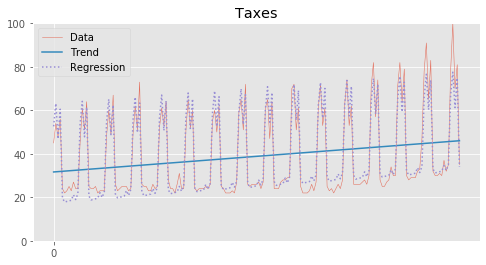

In [24]:
trend_df = taxes_df
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_title('Taxes')
ax.plot(trend_df['i'], trend_df['counts'], label='Data',
       linewidth=.5, alpha=.8)
ax.plot(trend_df['i'], trend_line, label='Trend')
ax.plot(trend_df['i'], lr_pred, label='Regression', linestyle="dotted")
plt.legend()
ticks = ax.get_xticks()
ax.set_ylim((0, 100))
ax.set_xticks([tick for tick in ticks if tick%24 == 0])
plt.show()

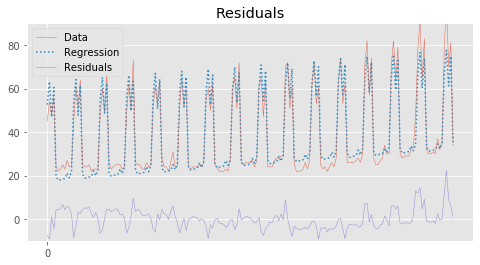

In [25]:
residuals = trend_df['counts'] - lr_pred

fig, ax = plt.subplots(figsize=(8, 4))
ax.set_title("Residuals")
ax.plot(trend_df['i'], trend_df['counts'], label='Data',
       linewidth=.5, alpha=.8)
ax.plot(trend_df['i'], lr_pred, label='Regression', linestyle="dotted")
ax.plot(trend_df['i'], residuals,
        label='Residuals', linewidth=.5)

#ax.plot(trend_df.index, trend_line, label='trend')
plt.legend()
ticks = ax.get_xticks()
ax.set_ylim((-10, 90))
ax.set_xticks([tick for tick in ticks if tick%24 == 0])
plt.show()

## Decomposing a Time Series

Statsmodels has a great tool for looking at a time series as a sum of parts: a general trend, a seasonality component, and whatever is left over (often called a residual (why?)): its `seasonal_decompose()` function.

In [26]:
taxes_df.index = pd.to_datetime(taxes_df.index)

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(taxes_df['counts'])

observed = decomposition.observed
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

/opt/anaconda3/envs/sklearn-0.22-env/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


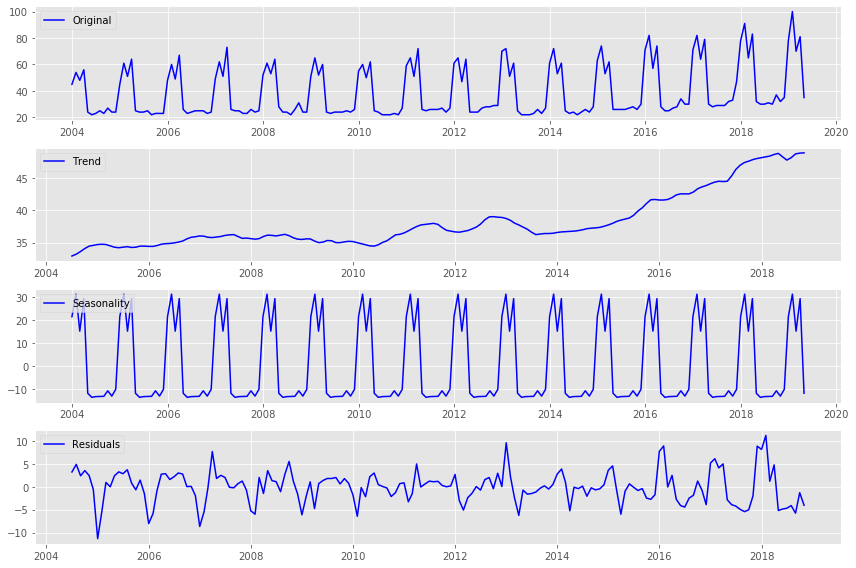

In [28]:
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(observed, label='Original', color="blue")
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(trend, label='Trend', color="blue")
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="blue")
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="blue")
plt.legend(loc='upper left')
plt.tight_layout()

Exercise to make sure that the residual really captures *all* remaining information about our times series.

For various techincal reasons that won't concern us here, some of the components of the decomposition have NANs at their heads and tails. But we can just use `np.nansum()`.

In [248]:
#trend.head()

In [29]:
myst = 0
for i in range(len(taxes_df['counts'])):
    myst += np.nansum(taxes_df['counts'][i] - trend[i] - seasonal[i] - residual[i])
myst

0.0